1.   Опишите модель данных (в любом удобном для вас представлении) для обслуживания библиотеки. Это может быть описание таблиц с типами данных, диаграмма – что угодно.

Представим модель данных в виде ER-диаграммы:

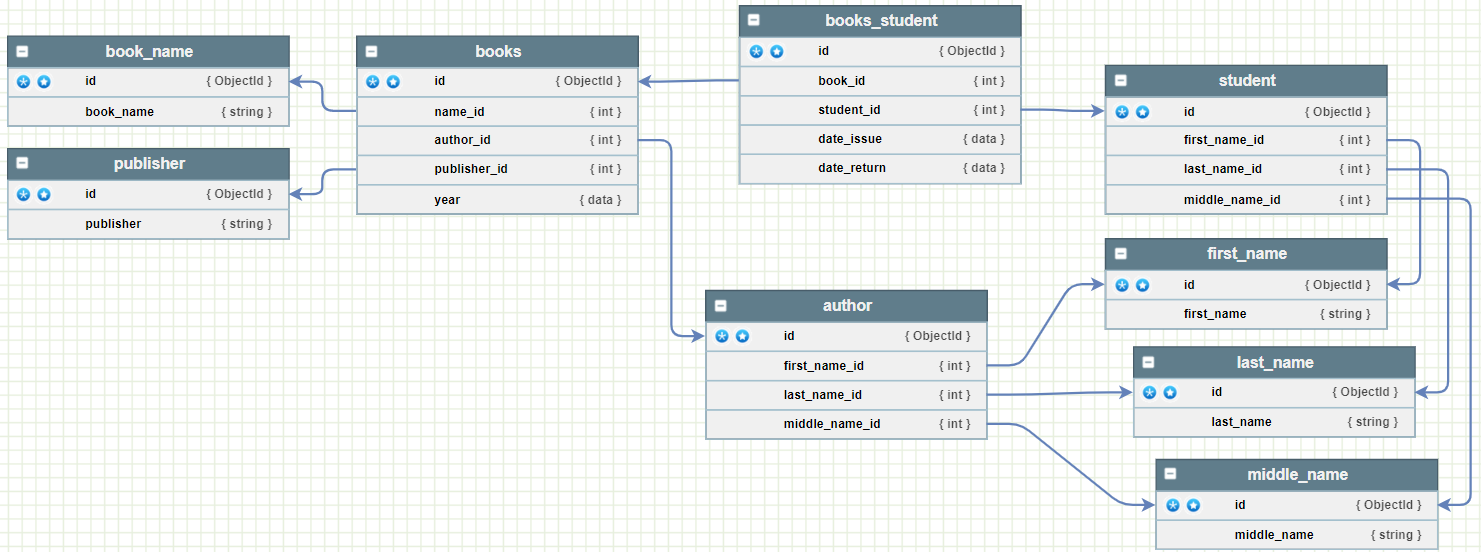

Создаём базу данных в SQLite исходя из данной диаграммы:

In [255]:
import sqlite3

conn = sqlite3.connect('library.sqlite')

cursor = conn.cursor()

def CreateTable():
    cursor.execute("""CREATE TABLE first_name (id serial PRIMARY KEY, first_name varchar(70));""")
    conn.commit()
    
    cursor.execute("""CREATE TABLE last_name (id serial PRIMARY KEY, last_name varchar(70));""")
    conn.commit()
    
    cursor.execute("""CREATE TABLE middle_name (id serial PRIMARY KEY, middle_name varchar(70));""")
    conn.commit()
    
    cursor.execute("""CREATE TABLE book_name (id serial PRIMARY KEY, book_name varchar(70));""")
    conn.commit()
    
    cursor.execute("""CREATE TABLE publisher (id serial PRIMARY KEY, publisher varchar(70));""")
    conn.commit()
    
    cursor.execute("""CREATE TABLE student (id serial PRIMARY KEY, 
    first_name_id INTEGER REFERENCES first_name(id), 
    last_name_id INTEGER REFERENCES  last_name(id),
    middle_name_id INTEGER REFERENCES  middle_name(id));""")
    conn.commit()
    
    cursor.execute("""CREATE TABLE author (id serial PRIMARY KEY, 
    first_name_id INTEGER REFERENCES first_name(id), 
    last_name_id INTEGER REFERENCES  last_name(id), 
    middle_name_id INTEGER REFERENCES  middle_name(id));""")
    conn.commit()
        
    cursor.execute("""CREATE TABLE books (id serial PRIMARY KEY, 
    name_id INTEGER REFERENCES book_name(id), 
    author_id INTEGER REFERENCES  author(id), 
    publisher_id INTEGER REFERENCES  publisher(id), year date);""")
    conn.commit()
        
    cursor.execute("""CREATE TABLE books_students (id serial PRIMARY KEY, 
    book_id INTEGER REFERENCES books(id), 
    student_id INTEGER REFERENCES  student(id), 
    date_issue date, date_return date);""")
    conn.commit()

CreateTable()

#conn.close()

Заполним базу данных:

In [256]:
def Filling():
    first_name = [(1,'Иван'),(2,'Василий'),(3,'Владимир'),(4,'Елена'),(5,'Арина'),(6,'Артур')]
    last_name = [(1,'Иванов'),(2,'Петров'),(3,'Авраменко'),(4,'Пермякова'),(5,'Василенко'),(6,'Пирогов')]
    middle_name = [(1,'Васильевич'),(2,'Иванович'),(3,'Петрович'),(4,'Владимировна'),(5,'Евгеньевна'),(6,'Витальевич')]
    
    cursor.executemany("INSERT INTO first_name VALUES(?, ?);", first_name)
    conn.commit()
    
    cursor.executemany("INSERT INTO last_name VALUES(?, ?);", last_name)
    conn.commit()
    
    cursor.executemany("INSERT INTO middle_name VALUES(?, ?);", middle_name)
    conn.commit()
    
    book_name = [(1,'Одиссея'),(2,'Повесть'),(3,'Рассказ'),(4,'Поэма')]
    
    cursor.executemany("INSERT INTO book_name VALUES(?, ?);", book_name)
    conn.commit()
    
    publisher = [(1,'Издательство новый век'),(2,'Издательство старый век')]
    
    cursor.executemany("INSERT INTO publisher VALUES(?, ?);", publisher)
    conn.commit()#= [(1,''),(2,''),(3,''),(4,''),(5,''),(6,'')]
    
    student = [(1,4,4,4),(2,5,5,5),(3,6,6,6)]
    
    cursor.executemany("INSERT INTO student VALUES(?, ?, ?, ?);", student)
    conn.commit()
    
    author = [(1,1,1,1),(2,2,2,2),(3,3,3,3)]
    
    cursor.executemany("INSERT INTO author VALUES(?, ?, ?, ?);", author)
    conn.commit()
    
    books = [(1,1,1,1,f'2000-01-01'),(2,2,2,1,f'2001-01-01'),(3,3,3,2,f'2002-01-01'),(4,4,1,2,f'2003-01-01')]
    
    cursor.executemany("INSERT INTO books VALUES(?, ?, ?, ?, ?);", books)
    conn.commit()
    
    books_students = [(1, 1, 1,f'2000-01-01',f'2000-02-01'),
                      (2, 2, 2,f'2000-02-01',f'2000-03-01'),
                      (3, 3, 3,f'2000-01-01',f'2000-04-01'),
                      (4, 4, 3,f'2000-01-01',f'2000-03-01'),
                      (5, 1, 2,f'2000-02-01',f'2000-03-01'),
                      (6, 1, 3,f'2000-01-01',f'2000-03-01'),
                      (7, 2, 3,f'2000-01-01',f'2000-03-01')]
    
    cursor.executemany("INSERT INTO books_students VALUES(?, ?, ?, ?, ?);", books_students)
    conn.commit()
    
Filling()

conn.close()

2.   Напишите SQL-запрос, который бы возвращал самого популярного автора за год. Запрос должен основываться на модели   данных, которую вы описали в задании 1. 

Запишем и выполним данный запрос:

In [258]:
conn = sqlite3.connect('library.sqlite')

cursor = conn.cursor()

cursor.execute("""SELECT first_name, middle_name, last_name
                FROM books_students bs
                INNER JOIN books b ON book_id = b.id
                INNER JOIN author a2 ON author_id = a2.id
                INNER JOIN first_name fn ON first_name_id = fn.id
                INNER JOIN middle_name mn ON middle_name_id = mn.id
                INNER JOIN last_name ln2 ON last_name_id = ln2.id
                WHERE bs.date_issue BETWEEN '2000-01-01' AND '2000-12-31'
                GROUP BY first_name, middle_name, last_name 
                ORDER BY COUNT(bs.id) DESC LIMIT 1;""")

result = cursor.fetchone()
print(result)

conn.close()

('Иван', 'Васильевич', 'Иванов')


3.   Определите понятие «злостный читатель».  Предложите алгоритм для поиска самого злостного читателя библиотеки. На любом языке программирования опишите алгоритм поиска такого читателя. Алгоритм должен основываться на модели данных,  которую вы описали в задании 1.

Примем, что «злостный читатель» - это такой читатель, у которого в среднем были допущены задержки возврата книг более чем на месяц (30 дней). Максимально допустимый срок возврата книг примем равным 30 дням.

Pапросим данные из БД и выполним дальнейшую обработку средствами Python:

In [259]:
import numpy as np
import datetime as dt
    
conn = sqlite3.connect('library.sqlite')

cursor = conn.cursor()

date30 = dt.timedelta(days=30)

cursor.execute("""SELECT first_name, middle_name, last_name, date_issue, date_return, student_id
                from books_students bs 
                INNER JOIN student s ON student_id = s.id
                INNER JOIN first_name fn ON first_name_id = fn.id
                INNER JOIN middle_name mn ON middle_name_id = mn.id
                INNER JOIN last_name ln ON last_name_id = ln.id
                WHERE bs.date_issue BETWEEN '2000-01-01' AND '2000-05-02'
                ORDER BY last_name;""")

zlo = cursor.fetchall()

cursor.execute("""SELECT COUNT(id) from student;""")
cStudent = cursor.fetchone()

counter = np.arange(cStudent[0]+1)
for i in range(cStudent[0]+1):
    counter[i] = 0

for x in zlo:
    counter[x[5]]+=1

format = '%Y-%m-%d'

cDay = np.arange(cStudent[0]+1)
for i in range(cStudent[0]+1):
    cDay[i] = 0

for x in zlo:
    kolvo = (dt.datetime.strptime(x[4], format) - dt.datetime.strptime(x[3], format) - date30) / date30
    if kolvo >= 1:
        cDay[x[5]] += int(kolvo)

for i in range(cStudent[0] + 1):
    if counter[i] != 0:
        if cDay[i] / counter[i] > 1:
            print(zlo[i][0] + " " + zlo[i][1] + " " + zlo[i][2]  + "\n")

conn.close()

Артур Витальевич Пирогов

